# Propensity Score Matching with DID: Use Case and Examples

Propensity score matching is a widely used causal inference analysis tool. As a data-preprocess tool, it can be combined with different estimation method such as inverse propensity score estimator, ordinary least square, DID (difference in difference), heterogeneuos treatment effect estimatior (HTE), etc. In this notebook, we'll demonstrate how to use the PSM to apply DID to synthetic data.

### Data

PSM in settings where we have several different types of observations:
* Covariates, which we will denote with `X`
* Treatment, which we will denote with `T`
* Responses, which we will denote with `Y`

Requirement is that `T` is a binary varible which contain only 0/1 values.

### Estimation

The PSM estimator uses a two-stage approach:
1. It estimates the *propensity score* of the treatment `T` given `X`, using a CART model you input.
2. It estimates the distance bewteen one obs and another using KNN and choose the nearest one.


In [1]:
# %reload_ext autoreload
# %autoreload 2
# import sys
# print(sys.path)
# sys.path.append('..') 

# Import the most update version of causalmatch
import causalmatch as causalmatch
from causalmatch import matching, gen_test_data, gen_test_data_panel_with_selection, gen_test_data_panel

print('current version is: ',causalmatch.__version__)

# check which python jupyter notebook links to
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

# Import the rest of dependencies
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,roc_auc_score,f1_score
import statsmodels.api as sm
from matplotlib import pyplot

# to use fixedeffect model, set pandas version to 1.3.5
from fixedeffect.fe import fixedeffect, did, getfe


['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/bytedance/Library/Python/3.12/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']
current version is:  0.0.5
/usr/local/bin/python3.12
3.12.2 (v3.12.2:6abddd9f6a, Feb  6 2024, 17:02:06) [Clang 13.0.0 (clang-1300.0.29.30)]
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


## 1. Generate synthetic data

To demonstrate the approach, we'll construct a synthetic dataset obeying the requirements set out above.  In this case, we'll take `X`, `T`, `y` to come from the following distribution: 

y_it = x_it * beta + treatment * ate + c_i + a_t + e_it



In [2]:
N = 50000
T = 10
beta = [-1, 0.2, 0.3, 0.5]
ate  = [5]

# 'exp_date': the date where treatment status for exp group swicth from 0 to 1
exp_date = 6

# 'unbalance':  not all id can observe all time periods value, ie. some obs can observe 10 days observation, some has only 1 obs.
unbalance = True

# df = gen_test_data_panel(N, T, beta, ate, exp_date, unbalance=True)

# Added selection bias during sample generation
df = gen_test_data_panel_with_selection(N, T, beta, ate, exp_date, unbalance=True)

df['id'] = df['id'].astype('int').astype('str')


# Add one more column of categorical covariates
np.random.seed(123456)
list_choice = list(range(5))
array_prob = np.random.rand(5)
list_prob = list(array_prob / np.sum(array_prob))

rand_discrete = np.random.choice(a = list_choice, size = [df.shape[0],1],p = list_prob)
df['x_discrete'] = rand_discrete.flatten()

print('For each id contains how many time periods observations')
print(df.groupby('id').time.nunique())

For each id contains how many time periods observations
id
1         8
10        8
100       9
1000      7
10000     8
         ..
9995     10
9996      9
9997      9
9998     10
9999     10
Name: time, Length: 50000, dtype: int64


## 2. Transform panel data to pre-treated cross-sectional data

Use pre-treated period cross sectional data to do matching. You can use either t_treat-1 data or t=0~t=t_treat-1's average.You can also include lagged y variable.


In [3]:
df_base = pd.DataFrame()


# 1. collect all ID
df_base['id'] = list(df['id'].value_counts().index)


# 2. collect all discrete variables, set each obs' value equals pre treatment's last period's
df['rank'] = df.groupby(['id'])['time'].transform('rank', method='first')
df_x_discrete = df[(df['time']<='date_04') & (df['rank']==1.0)][['id','x_discrete','rank']].copy()
df_x_discrete['x_discrete'] = df_x_discrete['x_discrete'].astype(object)


# 3. collect all id's treatment status
df_treat_status = pd.DataFrame(df.groupby('id').treatment.sum().copy())
df_treat_status.reset_index(inplace=True)
df_treat_status['treatment_'] = df_treat_status['treatment'].apply(lambda x: 1 if x > 0 else x)


# 4. collect all id's continuous variables, which equals pre-treated average
df_x_continuous_extract = df[df['time']<='date_04'][['id','x_0', 'x_1', 'x_2', 'x_3']].copy()
df_x_continuous = df_x_continuous_extract.groupby('id')[['x_0', 'x_1', 'x_2', 'x_3']].mean().copy()
df_x_continuous.reset_index(inplace=True)


# 5. merge data used for matching together
df_base1 = df_base.merge(df_x_discrete[['id','x_discrete']], how='left', on='id')
df_base2 = df_base1.merge(df_treat_status[['id','treatment_']], how='left', on='id')
df_base3 = df_base2.merge(df_x_continuous[['id','x_0', 'x_1', 'x_2', 'x_3']], how='left', on='id')

# 6. Because panel is imbalance, drop those obs with na values.
df_base3.dropna(inplace=True)
df_base3.reset_index(inplace=True, drop=True)

## 3. Match pre-treatment data using PSM

Use pre-treated data to do matching. 


In [4]:
# STEP 1: matching
match_obj = matching(data = df_base3,
                     T = 'treatment_',
                     X = ['x_1', 'x_2', 'x_3','x_discrete'],
                     id = 'id')

match_obj.psm(n_neighbors = 4, 
              model = LogisticRegression(), 
              trim_percentage = 0.01, 
              caliper = 1) 

res_post, res_pre = match_obj.balance_check(include_discrete = True)
res_pre['treat_control_diff_pre']  = (res_pre['Mean Treated pre-match'] - res_pre['Mean Control pre-match'])
res_pre['treat_control_diff_post'] = (res_post['Mean Treated post-match'] -res_post['Mean Control post-match'])

# Check if imbalance becomes balance
print(res_pre[['Covariates','treat_control_diff_pre','treat_control_diff_post']])


     Covariates  treat_control_diff_pre  treat_control_diff_post
0           x_1                  0.4681                   0.0017
1           x_2                  0.4015                   0.0022
2           x_3                  0.3707                  -0.0061
3  x_discrete_1                 -0.0011                  -0.0020
4  x_discrete_2                 -0.0013                  -0.0015
5  x_discrete_3                  0.0012                   0.0042
6  x_discrete_4                  0.0006                  -0.0007


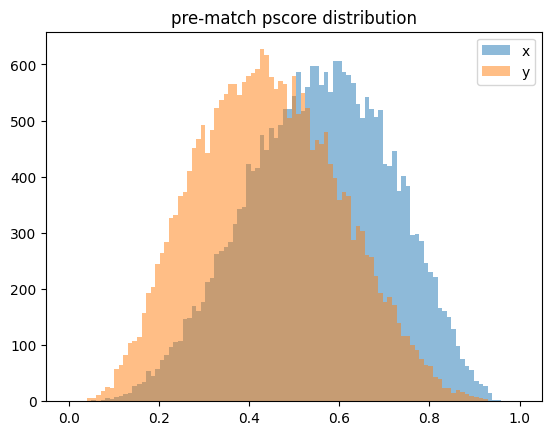

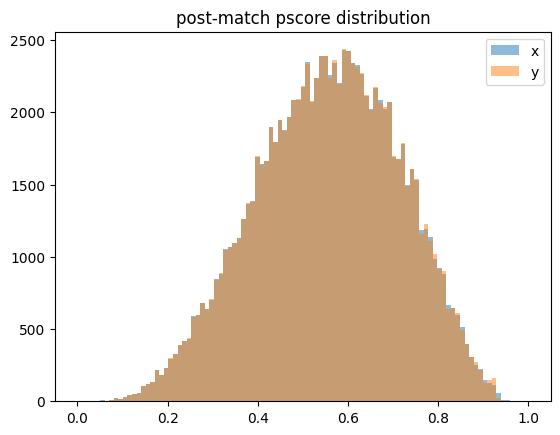

In [5]:

bins = np.linspace(0, 1, 100)

df_pre = match_obj.data_ps
pyplot.hist(df_pre[df_pre['treatment_']==1]['pscore'].values, bins, alpha=0.5, label='x')
pyplot.hist(df_pre[df_pre['treatment_']==0]['pscore'].values, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.title('pre-match pscore distribution')
pyplot.show()


pyplot.hist(match_obj.df_out_final['pscore_treat'].values, bins, alpha=0.5, label='x')
pyplot.hist(match_obj.df_out_final['pscore_control'].values, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.title('post-match pscore distribution')
pyplot.show()


## 4. DID

Use DID to estimate post-match data.


dependent variable(s): ['y']
independent(exogenous): []
category variables(fixed effects): ['id', 'time']
cluster variables: ['0']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fixedeffect/utils/GenCrossProd.py:55: UserWarning: You are doing DID with group effect where group is exp or base
  warnings.warn('You are doing DID with group effect where group is exp or base')


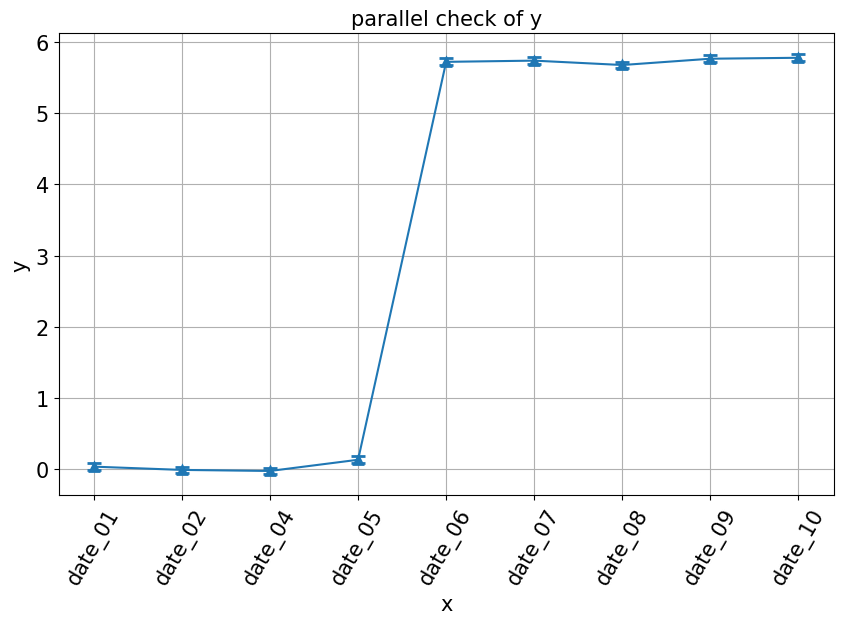

                    High Dimensional Fixed Effect Regression Results                   
  Dep. Variable:               y   R-squared(proj model):                      0.2519  
  No. Observations:       417923   Adj. R-squared(proj model):                 0.1585  
  DoF of residual:      371519.0   R-squared(full model):                      0.4434  
  Residual std err:       3.3737   Adj. R-squared(full model):                 0.3739  
  Covariance Type:     nonrobust   F-statistic(proj model):                 6.255e+04  
  Cluster Method:     no_cluster   Prob (F-statistic (proj model)):                 0  
                                   DoF of F-test (proj model):        [2.0, 371519.0]  
                                   F-statistic(full model):                    6.3787  
                                   Prob (F-statistic (full model)):                 0  
                                   DoF of F-test (full model):        [46404, 371519]  
                                

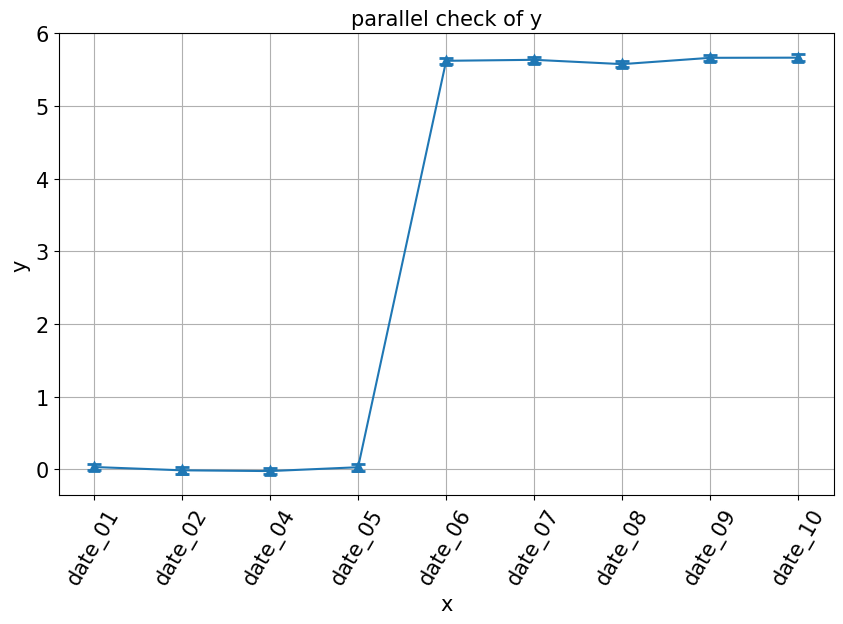

                    High Dimensional Fixed Effect Regression Results                   
  Dep. Variable:               y   R-squared(proj model):                      0.2599  
  No. Observations:       450001   Adj. R-squared(proj model):                 0.1673  
  DoF of residual:      399990.0   R-squared(full model):                      0.4448  
  Residual std err:       3.3163   Adj. R-squared(full model):                 0.3754  
  Covariance Type:     nonrobust   F-statistic(proj model):                 7.022e+04  
  Cluster Method:     no_cluster   Prob (F-statistic (proj model)):                 0  
                                   DoF of F-test (proj model):        [2.0, 399990.0]  
                                   F-statistic(full model):                    6.4077  
                                   Prob (F-statistic (full model)):                 0  
                                   DoF of F-test (full model):        [50011, 399990]  
                                

In [6]:
# Select those matched observation ID from original panel df
df_match_result = match_obj.df_out_final_post_trim
matched_id_list = df_match_result['id'].values
df_panel_post_match = df[df['id'].isin(matched_id_list)].copy()
df_panel_post_match.reset_index(inplace=True, drop=True)

formula = 'y ~ 0|0|0|0'


# post match result
model_did = did(data_df = df_panel_post_match,
                formula = formula,
                treatment = ['treatment'],
                csid = ['id'],
                tsid = ['time'],
                exp_date = 'date_04')
result = model_did.fit()
result.summary()


# pre match result
model_did = did(data_df = df,
                formula = formula,
                treatment = ['treatment'],
                csid = ['id'],
                tsid = ['time'],
                exp_date = 'date_04')
result = model_did.fit()
result.summary()